In [54]:
# define import
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import numpy as np

# Data Loading Pre-processing

In [5]:
import pickle
import random

with open("text_classification_train_words", "rb") as f:
    train = pickle.load(f)

with open("text_classification_test_words", "rb") as f:
    test = pickle.load(f)

print(f"{len(train)} samples in train")
print(f"{train[random.randint(0, len(train) - 1)]}")
print(f"{len(test)} samples in test")
print(f"{test[random.randint(0, len(test) - 1)]}")
print(len(train[0]['text']))

25000 samples in train
{'id': '2189', 'rating': 2, 'label': 0, 'text': 'This movie tells the tender tale of a demented scientist who, after his fiance is decapitated, goes around ogling strippers so that he can find a suitable body to attach her noggin to. Everyone in this movie exudes more slime than a snail, particularly our protagonist.', 'words': ['movie', 'tells', 'tender', 'tale', 'demented', 'scientist', 'fiance', 'decapitated', 'goes', 'around', 'ogling', 'strippers', 'find', 'suitable', 'body', 'attach', 'noggin', 'everyone', 'movie', 'exudes', 'slime', 'snail', 'particularly', 'protagonist']}
25000 samples in test
{'id': '8321', 'rating': 1, 'label': 0, 'text': 'Are we serious??? I mean wow ... just, wow. I think I saw this flick in an old issue of War Journal. This is pathetic, originality is completely dead, instead of trying to formulate a new idea what we receive is a bland re-do of an old plot line and to "switch it up" we just change the gender or race of the original c

In [6]:
# get vocab size
vocab = set()
i = 0
for sample in train + test:
    for word in sample['words']:
        vocab.add(word)

vocab_size = len(vocab)
print(f"Found a vocab size of {vocab_size}")

Found a vocab size of 133264


## Prepare to be embeddings

In [7]:
torch.manual_seed(1)

word_to_ix = {}

for i, word in enumerate(vocab):
    word_to_ix[word] = i

##  Split Training Data

In [8]:
def create_dataset(dataset):
    X, Y = [], []
    for data in dataset:
        embeddings = torch.tensor([torch.tensor([word_to_ix[word]], dtype=torch.long) for word in data['words']])
        X.append(embeddings)
        Y.append(data['label'])

    return pad_sequence(X, batch_first=True), torch.tensor(Y)


X_train, Y_train = create_dataset(train)
X_test, Y_test = create_dataset(test)

# Prepare For Training

In [9]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


## Training Func

In [29]:
learning_rate = 0.001 # Keep as is, or tune
def train_model(model, epochs):
    # Instantiate the model
    train_data = torch.utils.data.TensorDataset(X_train, Y_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    
    val_data = torch.utils.data.TensorDataset(X_test, Y_test)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    training_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss_epoch = 0
        num_batches = len(train_loader)
        for i, (batch_X, batch_y) in enumerate(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()
            print(f"Batch [{i}/{num_batches}]\r", end="")
        avg_train_loss = train_loss_epoch / len(train_loader)
        training_losses.append(avg_train_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_train_loss:.4f}\r')
    
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device) # Uncomment if using GPU
                outputs_val = model(batch_X_val)
                loss_val = criterion(outputs_val, batch_y_val)
                val_loss += loss_val.item()
    
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {avg_val_loss:.4f}')
        val_losses.append(avg_val_loss)
    
    print("Training complete.")
    return training_losses, val_losses
    
def test_model(model):
    # Calculate accuracy on the test set
    model.eval()  # Set the model to evaluation mode
    all_predicted_labels = []
    all_true_labels = []
    with torch.no_grad():
        correct = 0
        total = 0
        # Create a DataLoader for the test set
        test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, Y_test), batch_size=64, shuffle=False)
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            outputs_test = model(batch_X_test)
            _, predicted = torch.max(outputs_test.data, 1)
            total += batch_y_test.size(0)
            correct += (predicted == batch_y_test).sum().item()
            
            all_true_labels.extend(batch_y_test.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())
    
        accuracy = 100 * correct / total
        print(f'Accuracy of the model on the test data: {accuracy:.2f}%')
        
        report = classification_report(all_true_labels, all_predicted_labels, target_names=["Negative", "Positive"])
        return report

# RNN Model

In [49]:
# define our model class
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn1_hidden_size, rnn2_hidden_size, dense_hidden_size, dropout_p=0.5):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.rnn1 = nn.RNN(embedding_dim,
                           rnn1_hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.dropout_rnn1 = nn.Dropout(dropout_p)

        self.rnn2 = nn.RNN(rnn1_hidden_size * 2,
                           rnn2_hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.dropout_rnn2 = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(rnn2_hidden_size * 2, dense_hidden_size)
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(dropout_p)

        # Final output layer
        self.fc2 = nn.Linear(dense_hidden_size, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_embed(x) # Shape: (batch_size, seq_len, embedding_dim)

        rnn1_out, _ = self.rnn1(x)
        rnn1_out = self.dropout_rnn1(rnn1_out)

        _, hn_rnn2 = self.rnn2(rnn1_out)

        hidden_combined = torch.cat((hn_rnn2[0, :, :], hn_rnn2[1, :, :]), dim=1)
        
        out_fc1 = self.fc1(hidden_combined)
        out_relu = self.relu(out_fc1)
        out_dropout_fc1 = self.dropout_fc1(out_relu)

        # Final output layer
        out = self.fc2(out_dropout_fc1) # Shape: (batch_size, output_size)
        return out

In [50]:
embedding_dim = 256
rnn1_hidden_size = 64 
rnn2_hidden_size = 16
dense_hidden_size = 32
dropout_rate = 0.2
epochs = 10  # Number of epochs

# Instantiate the model
rnn_model = RNN(vocab_size, embedding_dim, rnn1_hidden_size, rnn2_hidden_size, dense_hidden_size).to(device)
training_losses, val_losses = train_model(rnn_model, epochs)

Epoch [1/2], Training Loss: 0.6971
Epoch [1/2], Validation Loss: 0.6896
Epoch [2/2], Training Loss: 0.6895
Epoch [2/2], Validation Loss: 0.6691
Training complete.


In [51]:
report = test_model(rnn_model)
print(report)

Accuracy of the model on the test data: 59.83%
              precision    recall  f1-score   support

    Negative       0.61      0.55      0.58     12500
    Positive       0.59      0.64      0.62     12500

    accuracy                           0.60     25000
   macro avg       0.60      0.60      0.60     25000
weighted avg       0.60      0.60      0.60     25000



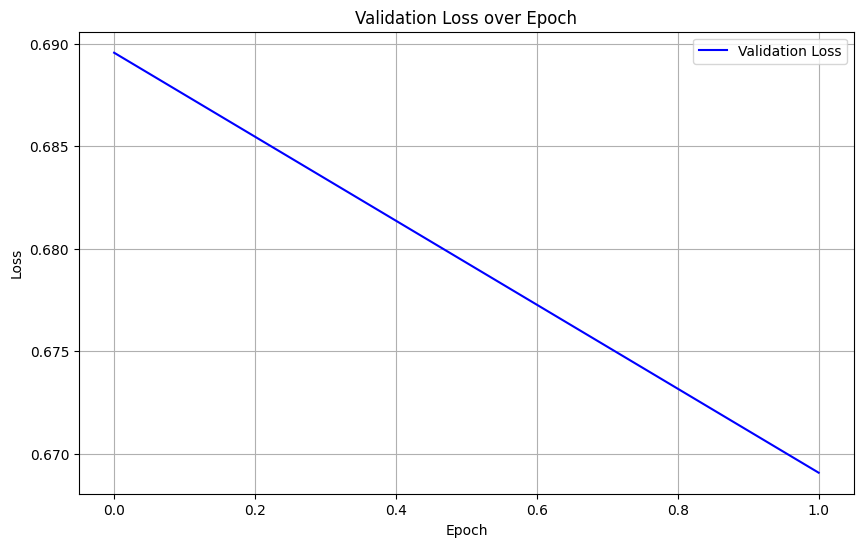

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label='Validation Loss', color='blue')
plt.title("Validation Loss over Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
# define our model class
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, gru1_hidden_size, gru2_hidden_size, dense_hidden_size, output_size, dropout_p=0.5):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.gru1 = nn.GRU(embedding_dim,
                           gru1_hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.dropout_gru1 = nn.Dropout(dropout_p)

        self.gru2 = nn.GRU(gru1_hidden_size * 2,
                           gru2_hidden_size,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.dropout_gru2 = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(gru2_hidden_size * 2, dense_hidden_size)
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(dropout_p)

        # Final output layer
        self.fc2 = nn.Linear(dense_hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_embed(x) # Shape: (batch_size, seq_len, embedding_dim)

        gru1_out, _ = self.gru1(x)
        gru1_out = self.dropout_gru1(gru1_out)

        _, hn_gru2 = self.gru2(gru1_out)

        hidden_combined = torch.cat((hn_gru2[0, :, :], hn_gru2[1, :, :]), dim=1)
        
        out_fc1 = self.fc1(hidden_combined)
        out_relu = self.relu(out_fc1)
        out_dropout_fc1 = self.dropout_fc1(out_relu)

        # Final output layer
        out = self.fc2(out_dropout_fc1) # Shape: (batch_size, output_size)
        return out

In [16]:
embedding_dim = 256
gru1_hidden_size = 128 
gru2_hidden_size = 64
dense_hidden_size = 64
dropout_rate = 0.2

output_size = 2 # binary classification (remains the same)
learning_rate = 0.001 # Keep as is, or tune
epochs = 10  # Keep as is, or tune

# Instantiate the model with new parameters
gru_model = GRU(vocab_size,
            embedding_dim,
            gru1_hidden_size,
            gru2_hidden_size,
            dense_hidden_size,
            output_size,
            dropout_p=dropout_rate).to(device)
training_losses, val_losses = train_model(gru_model, epochs)

Epoch [1/2], Training Loss: 0.6267
Epoch [1/2], Validation Loss: 0.5482
Epoch [2/2], Training Loss: 0.3970
Epoch [2/2], Validation Loss: 0.3288
Training complete.


In [ ]:
report = test_model(gru_model)
print(report)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label='Validation Loss', color='blue')
plt.title("Validation Loss over Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# LSTM Model

In [8]:
# define our model class
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm1_hidden_size, lstm2_hidden_size, dense_hidden_size, output_size, dropout_p=0.5):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout_embed = nn.Dropout(dropout_p)

        self.lstm1 = nn.LSTM(embedding_dim,
                             lstm1_hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True)
        self.dropout_lstm1 = nn.Dropout(dropout_p)

        self.lstm2 = nn.LSTM(lstm1_hidden_size * 2,
                             lstm2_hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True)
        self.dropout_lstm2 = nn.Dropout(dropout_p)

        self.fc1 = nn.Linear(lstm2_hidden_size * 2, dense_hidden_size)
        self.relu = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(dropout_p)

        # Final output layer
        self.fc2 = nn.Linear(dense_hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout_embed(x) # Shape: (batch_size, seq_len, embedding_dim)

        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout_lstm1(lstm1_out)

        _, hn_gru2 = self.lstm2(lstm1_out)

        hidden_combined = torch.cat((hn_gru2[0, :, :], hn_gru2[1, :, :]), dim=1)
        
        out_fc1 = self.fc1(hidden_combined)
        out_relu = self.relu(out_fc1)
        out_dropout_fc1 = self.dropout_fc1(out_relu)

        # Final output layer
        out = self.fc2(out_dropout_fc1) # Shape: (batch_size, output_size)
        return out

In [9]:
embedding_dim = 256
lstm1_hidden_size = 128 
lstm2_hidden_size = 64
dense_hidden_size = 64
dropout_rate = 0.2

output_size = 2 # binary classification (remains the same)
epochs = 10  # Keep as is, or tune

# Instantiate the model with new parameters
lstm_model = LSTM(vocab_size,
            embedding_dim,
            gru1_hidden_size,
            gru2_hidden_size,
            dense_hidden_size,
            output_size,
            dropout_p=dropout_rate).to(device)
training_losses, val_losses = train_model(lstm_model, epochs)

Original dataset size: 25000
Training subset size: 22500
Validation subset size: 2500
Number of trainable parameters: 34684098
Epoch [1/20], Training Loss: 0.6199
Epoch [1/20], Validation Loss: 0.6827
Epoch [2/20], Training Loss: 0.4863
Epoch [2/20], Validation Loss: 0.4151
Epoch [3/20], Training Loss: 0.3312
Epoch [3/20], Validation Loss: 0.3368
Epoch [4/20], Training Loss: 0.2483
Epoch [4/20], Validation Loss: 0.3790
Epoch [5/20], Training Loss: 0.1846
Epoch [5/20], Validation Loss: 0.3731
Epoch [6/20], Training Loss: 0.1324
Epoch [6/20], Validation Loss: 0.3778
Epoch [7/20], Training Loss: 0.0931
Epoch [7/20], Validation Loss: 0.3789
Epoch [8/20], Training Loss: 0.0680
Epoch [8/20], Validation Loss: 0.4354
Epoch [9/20], Training Loss: 0.0463
Epoch [9/20], Validation Loss: 0.5011
Epoch [10/20], Training Loss: 0.0354
Epoch [10/20], Validation Loss: 0.5169
Epoch [11/20], Training Loss: 0.0317
Epoch [11/20], Validation Loss: 0.5119
Epoch [12/20], Training Loss: 0.0291
Epoch [12/20], Val

In [10]:
report = test_model(lstm_model)
print(report)

Accuracy of the model on the test data: 85.27%


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val_losses, label='Validation Loss', color='blue')
plt.title("Validation Loss over Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()